# Predict monthly data, single city

In [1]:
import os
from pathlib import Path
from prophet import Prophet

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
iskaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")
if iskaggle:
    path = Path("../rohanrao/air-quality-data-in-india")
else:
    full_path = Path("rohanrao/air-quality-data-in-india")
    owner_slug = str(full_path).split("/")[0]
    dataset_slug = str(full_path).split("/")[1]
    path = Path(dataset_slug)
    if not path.exists():
        import zipfile, kaggle

        kaggle.api.datasets_download(owner_slug=owner_slug, dataset_slug=dataset_slug)

In [3]:
import zipfile

zipfile.ZipFile(f"{dataset_slug}.zip").extractall(dataset_slug)

In [4]:
import torch, numpy as np, pandas as pd

In [5]:
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option("display.width", 140)

In [6]:
df = pd.read_csv(path / "city_day.csv")
df

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,0.73,41.0,Good
29527,Visakhapatnam,2020-06-28,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,0.38,70.0,Satisfactory
29528,Visakhapatnam,2020-06-29,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,0.00,68.0,Satisfactory
29529,Visakhapatnam,2020-06-30,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,0.00,54.0,Satisfactory


In [7]:
df.dtypes

City           object
Date           object
PM2.5         float64
PM10          float64
NO            float64
NO2           float64
NOx           float64
NH3           float64
CO            float64
SO2           float64
O3            float64
Benzene       float64
Toluene       float64
Xylene        float64
AQI           float64
AQI_Bucket     object
dtype: object

In [8]:
df.Date = pd.to_datetime(df.Date)
df.dtypes

City                  object
Date          datetime64[ns]
PM2.5                float64
PM10                 float64
NO                   float64
NO2                  float64
NOx                  float64
NH3                  float64
CO                   float64
SO2                  float64
O3                   float64
Benzene              float64
Toluene              float64
Xylene               float64
AQI                  float64
AQI_Bucket            object
dtype: object

In [9]:
df.isna().sum()

City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

In [10]:
modes = df.mode().iloc[0]
modes

City                    Ahmedabad
Date          2020-03-11 00:00:00
PM2.5                        11.0
PM10                         94.0
NO                           5.93
NO2                         10.58
NOx                           0.0
NH3                          6.29
CO                            0.0
SO2                          5.74
O3                          16.48
Benzene                       0.0
Toluene                       0.0
Xylene                        0.0
AQI                         102.0
AQI_Bucket               Moderate
Name: 0, dtype: object

In [11]:
df.describe(include=(np.number))

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,24933.000000,18391.000000,25949.000000,25946.000000,25346.000000,19203.000000,27472.000000,25677.000000,25509.000000,23908.000000,21490.000000,11422.000000,24850.000000
mean,67.450578,118.127103,17.574730,28.560659,32.309123,23.483476,2.248598,14.531977,34.491430,3.280840,8.700972,3.070128,166.463581
std,64.661449,90.605110,22.785846,24.474746,31.646011,25.684275,6.962884,18.133775,21.694928,15.811136,19.969164,6.323247,140.696585
min,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000
25%,28.820000,56.255000,5.630000,11.750000,12.820000,8.580000,0.510000,5.670000,18.860000,0.120000,0.600000,0.140000,81.000000
50%,48.570000,95.680000,9.890000,21.690000,23.520000,15.850000,0.890000,9.160000,30.840000,1.070000,2.970000,0.980000,118.000000
75%,80.590000,149.745000,19.950000,37.620000,40.127500,30.020000,1.450000,15.220000,45.570000,3.080000,9.150000,3.350000,208.000000
max,949.990000,1000.000000,390.680000,362.210000,467.630000,352.890000,175.810000,193.860000,257.730000,455.030000,454.850000,170.370000,2049.000000


<AxesSubplot:>

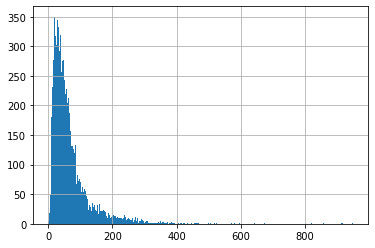

In [12]:
df["PM2.5"].hist(bins=1000)

In [13]:
df["LogPM2.5"] = np.log(df["PM2.5"] + 1)

<AxesSubplot:>

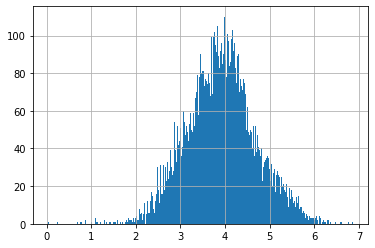

In [14]:
df["LogPM2.5"].hist(bins=1000)

In [15]:
cities = sorted(df.City.unique())
print(cities)

['Ahmedabad', 'Aizawl', 'Amaravati', 'Amritsar', 'Bengaluru', 'Bhopal', 'Brajrajnagar', 'Chandigarh', 'Chennai', 'Coimbatore', 'Delhi', 'Ernakulam', 'Gurugram', 'Guwahati', 'Hyderabad', 'Jaipur', 'Jorapokhar', 'Kochi', 'Kolkata', 'Lucknow', 'Mumbai', 'Patna', 'Shillong', 'Talcher', 'Thiruvananthapuram', 'Visakhapatnam']


In [16]:
df.describe(include=[object])

,City,AQI_Bucket
count,29531,24850
unique,26,6
top,Ahmedabad,Moderate
freq,2009,8829


In [17]:
delhi_df = df[df["City"] == "Delhi"]
delhi_df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,LogPM2.5
10229,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe,5.750093
10230,Delhi,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe,5.232071
10231,Delhi,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate,4.479380
10232,Delhi,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor,5.029392
10233,Delhi,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor,4.994506


In [18]:
delhi_df.isna().sum()

City            0
Date            0
PM2.5           2
PM10           77
NO              2
NO2             2
NOx             0
NH3             9
CO              0
SO2           110
O3             84
Benzene         0
Toluene         0
Xylene        781
AQI            10
AQI_Bucket     10
LogPM2.5        2
dtype: int64

In [19]:
modes = delhi_df.mode().iloc[0]
modes

City                        Delhi
Date          2015-01-01 00:00:00
PM2.5                       42.06
PM10                        60.15
NO                          14.64
NO2                         38.55
NOx                         20.45
NH3                         31.36
CO                            0.0
SO2                          9.36
O3                          34.75
Benzene                      1.88
Toluene                       0.0
Xylene                        0.0
AQI                         123.0
AQI_Bucket                   Poor
LogPM2.5                 3.762594
Name: 0, dtype: object

In [20]:
delhi_df.fillna(modes, inplace=True)

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [21]:
print(delhi_df.isna().sum())

City          0
Date          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
LogPM2.5      0
dtype: int64


In [22]:
delhi_df_monthly = delhi_df.set_index(keys=["Date"]).resample("M").mean()
delhi_df_monthly.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,LogPM2.5
Date,,,,,,,,,,,,,,
2015-01-31,175.690645,276.971290,26.392581,36.925484,51.794194,98.160323,10.269355,5.594194,25.868710,5.265161,10.913548,3.730323,342.290323,5.149637
2015-02-28,153.920357,234.939643,29.287857,41.656786,54.208571,65.785714,11.137857,7.863214,30.829643,3.969286,9.411429,6.012857,327.928571,5.031690
2015-03-31,80.338065,135.044516,15.010000,24.386129,30.734194,27.790323,9.863871,7.387097,28.738387,3.066452,8.617097,5.790968,256.064516,4.356730
2015-04-30,91.562333,187.991333,18.510667,44.279667,54.751000,32.401667,7.218333,16.101333,58.172000,3.143333,9.826667,2.949667,305.266667,4.493908
2015-05-31,97.109355,271.050645,30.833871,61.483548,78.628065,38.922903,8.008387,16.129032,69.061613,3.072581,10.062581,0.071290,348.580645,4.552019


<AxesSubplot:xlabel='Date'>

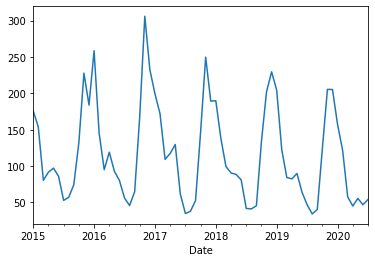

In [23]:
delhi_df_monthly["PM2.5"].plot()

In [24]:
delhi_df_monthly = delhi_df_monthly.reset_index(drop=False)
delhi_df_monthly["Date"].head()

0   2015-01-31
1   2015-02-28
2   2015-03-31
3   2015-04-30
4   2015-05-31
Name: Date, dtype: datetime64[ns]

In [25]:
nobs = 12
train = delhi_df_monthly[:-nobs]
test = delhi_df_monthly[-nobs:]

print(
    f"Length of dataframe: {len(delhi_df_monthly)}\n"
    f"Length of train set: {len(train)}\n"
    f"Length of test set: {len(test)}"
)

Length of dataframe: 67
Length of train set: 55
Length of test set: 12


In [26]:
forecaster = Prophet()
forecaster.fit(train.rename(columns={"Date": "ds", "PM2.5": "y"}))

10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6


RuntimeError: Error during optimization: console log output:

dyld[27666]: Library not loaded: @rpath/libtbb.dylib
  Referenced from: /Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin
  Reason: tried: '/private/var/folders/17/sgfdr00n1sn9ddjf831jrsd00000gn/T/pip-req-build-upggi27i/build/lib.macosx-12.0-arm64-cpython-39/prophet/stan_model/cmdstan-2.26.1/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/17/sgfdr00n1sn9ddjf831jrsd00000gn/T/pip-req-build-upggi27i/build/lib.macosx-12.0-arm64-cpython-39/prophet/stan_model/cmdstan-2.26.1/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/usr/local/lib/libtbb.dylib' (no such file), '/usr/lib/libtbb.dylib' (no such file)


In [44]:
import datetime

# construct future dataframe
n_future_months = 12
begin_ds = train["Date"].max()
month = begin_ds.month
year = begin_ds.year
future_dates = []
for _ in range(n_future_months):
    month += 1
    if month > 12:
        month = 1
        year += 1
    future_dates.append(datetime.datetime(year=year, month=month, day=1))

future_dates[:5]

[datetime.datetime(2019, 8, 1, 0, 0),
 datetime.datetime(2019, 9, 1, 0, 0),
 datetime.datetime(2019, 10, 1, 0, 0),
 datetime.datetime(2019, 11, 1, 0, 0),
 datetime.datetime(2019, 12, 1, 0, 0)]

In [46]:
future = pd.DataFrame({"ds": future_dates})

future.head()

,ds
0,2019-08-01
1,2019-09-01
2,2019-10-01
3,2019-11-01
4,2019-12-01


In [47]:
forecast = forecaster.predict(future)

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [48]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08-01,119.835968,11.305546,42.842058,119.835968,119.835968,-92.783578,-92.783578,-92.783578,-92.783578,-92.783578,-92.783578,0.0,0.0,0.0,27.052389
1,2019-09-01,119.117931,-1.807665,29.826464,119.099541,119.132877,-104.674826,-104.674826,-104.674826,-104.674826,-104.674826,-104.674826,0.0,0.0,0.0,14.443104
2,2019-10-01,118.423056,10.819798,40.932621,118.340866,118.494934,-93.436035,-93.436035,-93.436035,-93.436035,-93.436035,-93.436035,0.0,0.0,0.0,24.987021
3,2019-11-01,117.705019,125.719588,155.644435,117.533068,117.862908,22.617475,22.617475,22.617475,22.617475,22.617475,22.617475,0.0,0.0,0.0,140.322494
4,2019-12-01,117.010144,264.381159,294.726610,116.734010,117.265034,162.805370,162.805370,162.805370,162.805370,162.805370,162.805370,0.0,0.0,0.0,279.815514


In [49]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
7,2020-03-01,123.551207,107.992035,140.595322
8,2020-04-01,85.584592,68.774882,101.210514
9,2020-05-01,137.496593,121.695405,152.644668
10,2020-06-01,98.970866,83.672294,114.190011
11,2020-07-01,45.261225,28.931209,60.608969


In [50]:
forecast = forecaster.predict(future)

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [51]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08-01,119.835968,10.080689,42.515601,119.835968,119.835968,-92.783578,-92.783578,-92.783578,-92.783578,-92.783578,-92.783578,0.0,0.0,0.0,27.052389
1,2019-09-01,119.117931,-1.302174,30.260249,119.095171,119.136229,-104.674826,-104.674826,-104.674826,-104.674826,-104.674826,-104.674826,0.0,0.0,0.0,14.443104
2,2019-10-01,118.423056,9.042641,40.836508,118.345461,118.498941,-93.436035,-93.436035,-93.436035,-93.436035,-93.436035,-93.436035,0.0,0.0,0.0,24.987021
3,2019-11-01,117.705019,125.502172,155.881111,117.548457,117.873967,22.617475,22.617475,22.617475,22.617475,22.617475,22.617475,0.0,0.0,0.0,140.322494
4,2019-12-01,117.010144,263.732534,295.005735,116.746880,117.294468,162.805370,162.805370,162.805370,162.805370,162.805370,162.805370,0.0,0.0,0.0,279.815514


In [52]:
forecast.ds.describe()

/var/folders/63/m20qx7592pb4b2zvqmy711qc0000gn/T/ipykernel_50318/2228427570.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  forecast.ds.describe()


count                      12
unique                     12
top       2019-08-01 00:00:00
freq                        1
first     2019-08-01 00:00:00
last      2020-07-01 00:00:00
Name: ds, dtype: object

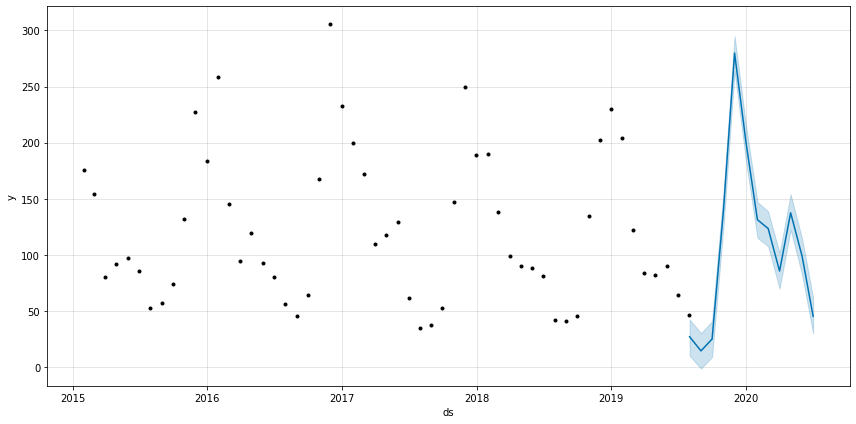

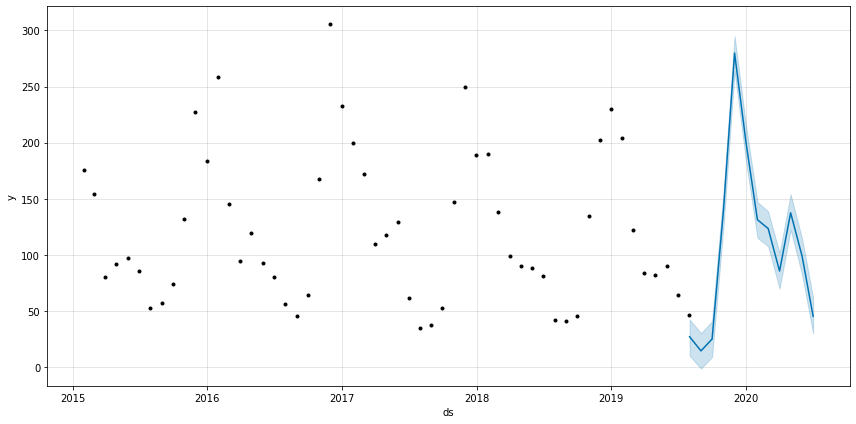

In [53]:
forecaster.plot(forecast, figsize=(12, 6))

## Comparing predictions to actual values

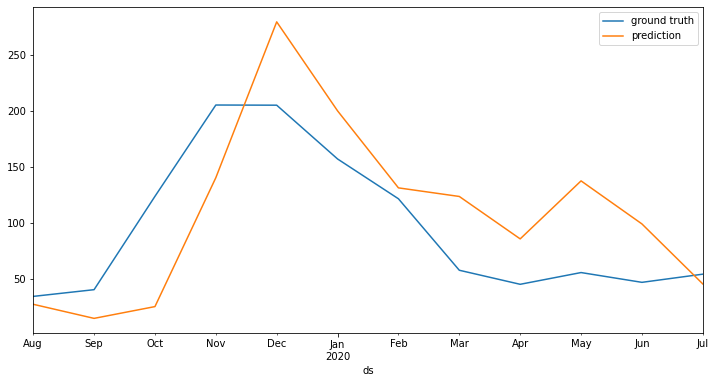

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
test.rename(columns={"Date": "ds", "PM2.5": "y"}).set_index(keys=["ds"])["y"].plot()
forecast.set_index(keys=["ds"]).iloc[-nobs:, :]["yhat"].plot()


ax.legend(["ground truth", "prediction"])
plt.show()

In [ ]:
#TODO: take single year's data, make prediction, then 2 years etc. (which timespan gives best prediction?)
#TODO: try a prediction for 2023 (each Indian city)
#TODO: Plot weekly prediction for each city
# consdier location in country also

# External datasets as well - wind speed / direction & temperature
# Which method performs best with Pollution data
# Which metrics to use to find which method perform the best